/tmp/ipykernel_55/2528279607.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette='magma')


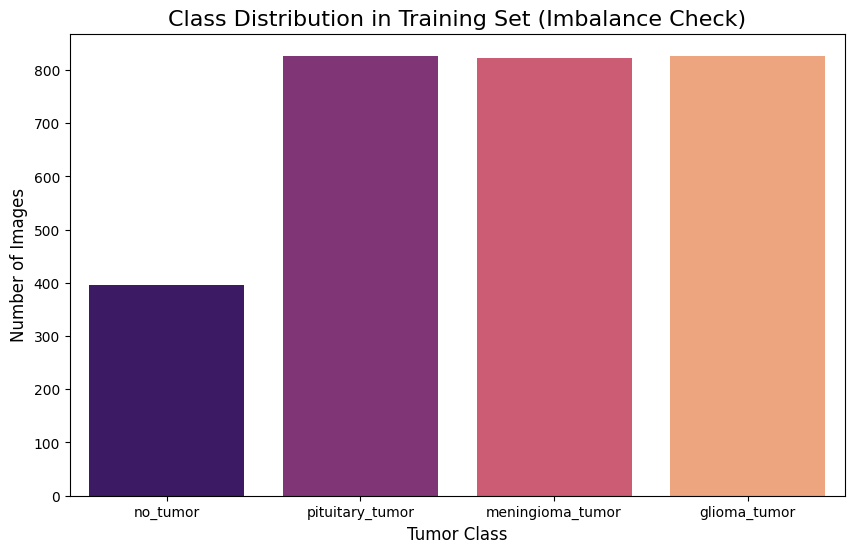

Training Set
- no_tumor: 395 images
- pituitary_tumor: 827 images
- meningioma_tumor: 822 images
- glioma_tumor: 826 images

(Minority): no_tumor (GAN)
(Majority): pituitary_tumor


In [41]:
import os
import matplotlib.pyplot as plt
import seaborn as sns


train_dir = '/kaggle/input/brain-tumor/Training'  

classes = []
counts = []

if os.path.exists(train_dir):
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        
        if os.path.isdir(class_path):
            classes.append(class_name)
            num_images = len(os.listdir(class_path))
            counts.append(num_images)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=classes, y=counts, palette='magma')
    
    plt.title('Class Distribution in Training Set (Imbalance Check)', fontsize=16)
    plt.xlabel('Tumor Class', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.show()

    print("Training Set")
    for c, n in zip(classes, counts):
        print(f"- {c}: {n} images")

    if counts:
        minority_class = classes[counts.index(min(counts))]
        majority_class = classes[counts.index(max(counts))]
        print(f"\n(Minority): {minority_class} (GAN)")
        print(f"(Majority): {majority_class}")

Index of 'no_tumor' class is: 2
395  no_tumor ready for treaning.


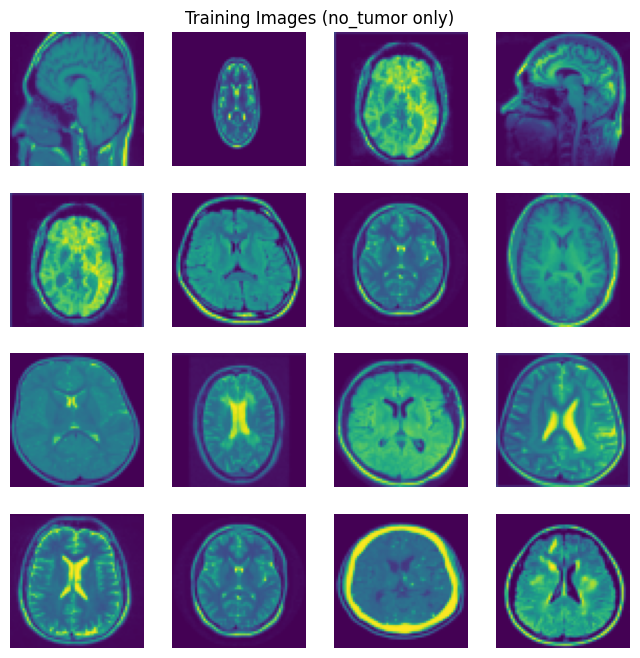

In [42]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 64
BATCH_SIZE = 32


DATA_PATH = '/kaggle/input/brain-tumor/Training' 

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = datasets.ImageFolder(root=DATA_PATH, transform=transform)

target_class_idx = full_dataset.class_to_idx['no_tumor']
print(f"Index of 'no_tumor' class is: {target_class_idx}")

minority_indices = [i for i, label in enumerate(full_dataset.targets) if label == target_class_idx]
minority_dataset = torch.utils.data.Subset(full_dataset, minority_indices)

dataloader = DataLoader(minority_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"{len(minority_dataset)}  no_tumor ready for treaning.")

def show_sample_batch(loader):
    images, _ = next(iter(loader))
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Training Images (no_tumor only)")
    
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.axis("off")
        img = images[i].numpy().transpose((1, 2, 0))
        img = (img * 0.5) + 0.5 
        plt.imshow(img)
    plt.show()

show_sample_batch(dataloader)

In [43]:
import torch.nn as nn
import torch.optim as optim

z_dim = 150       
lr = 0.0002        
image_dim = 64 * 64 * 1 

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_dim),
            nn.Tanh()   
        )

    def forward(self, x):
        return self.net(x).view(-1, 1, 64, 64) 

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() 
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

gen = Generator().to(device)
disc = Discriminator().to(device)

# --- المُحسّنات (Optimizers) ---
opt_gen = optim.Adam(gen.parameters(), lr=lr)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
criterion = nn.BCELoss() 

Using device: cuda


Epoch [20/200]  Loss D: 1.0045, Loss G: 0.2546


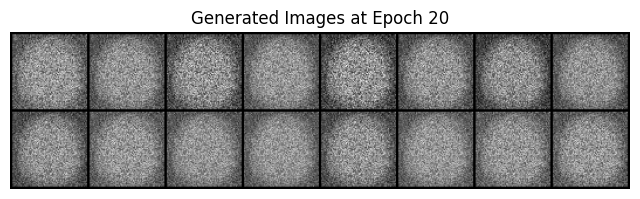

Epoch [40/200]  Loss D: 0.0106, Loss G: 5.3970


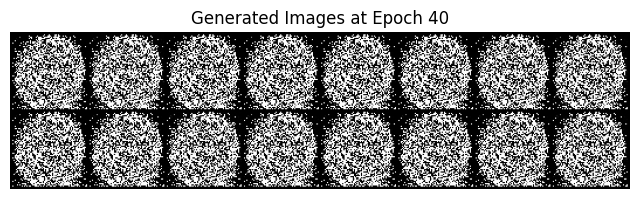

Epoch [60/200]  Loss D: 0.0010, Loss G: 8.1566


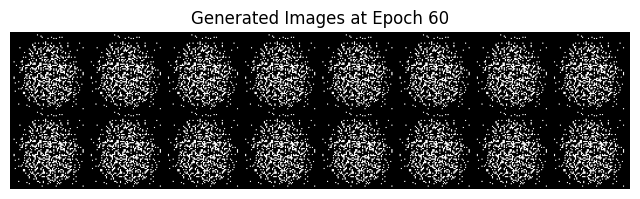

Epoch [80/200]  Loss D: 0.0007, Loss G: 8.6974


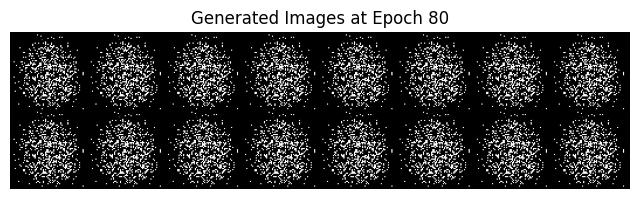

Epoch [100/200]  Loss D: 0.0004, Loss G: 8.7286


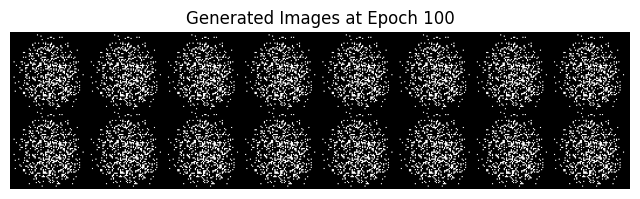

Epoch [120/200]  Loss D: 0.0015, Loss G: 7.2698


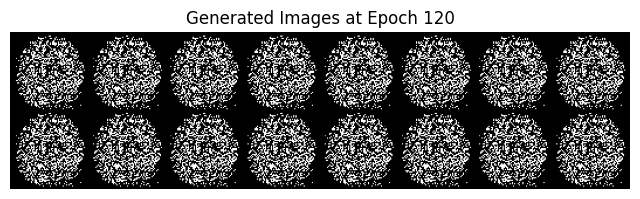

Epoch [140/200]  Loss D: 0.0013, Loss G: 7.4978


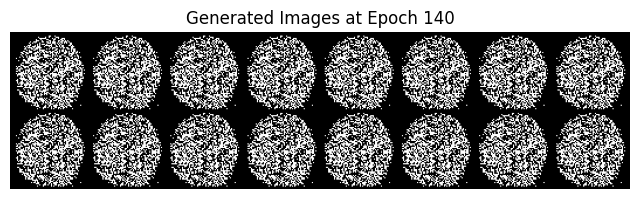

Epoch [160/200]  Loss D: 0.0005, Loss G: 8.3064


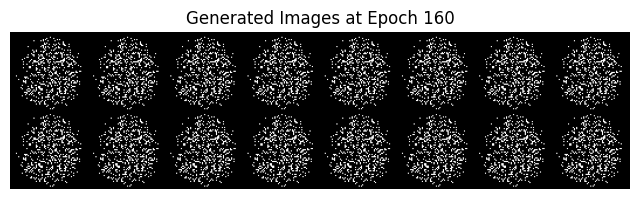

Epoch [180/200]  Loss D: 0.0000, Loss G: 10.8028


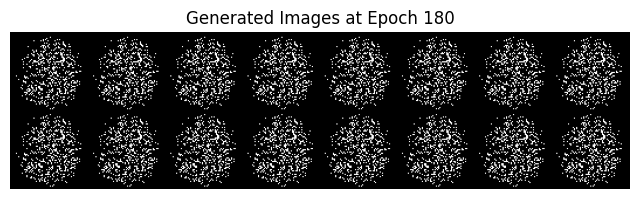

Epoch [200/200]  Loss D: 0.0000, Loss G: 11.5328


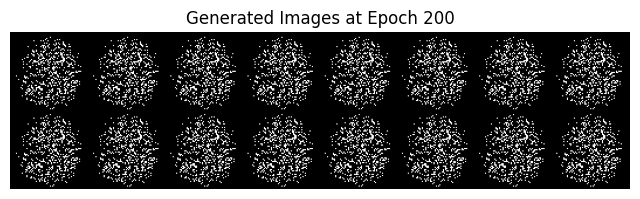

In [44]:
import torchvision.utils as vutils

num_epochs = 200
fixed_noise = torch.randn(16, z_dim).to(device) 


for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.shape[0]

        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        
        disc_real = disc(real).view(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        
        disc_fake = disc(fake.detach()).view(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        output = disc(fake).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]  Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")
        with torch.no_grad():
            fake_images = gen(fixed_noise).cpu()

            plt.figure(figsize=(8, 4))
            plt.axis("off")
            plt.title(f"Generated Images at Epoch {epoch+1}")
            plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
            plt.show()

In [45]:
#DCGAN

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netG = DCGAN_Generator().to(device)
netG.apply(weights_init) 

netD = DCGAN_Discriminator().to(device)
netD.apply(weights_init)

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

Starting DCGAN Training Loop...
Epoch [20/300]


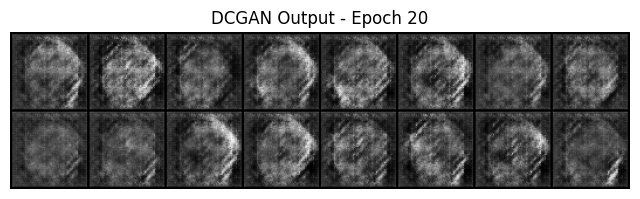

Epoch [40/300]


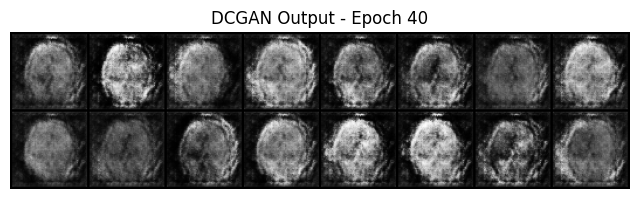

Epoch [60/300]


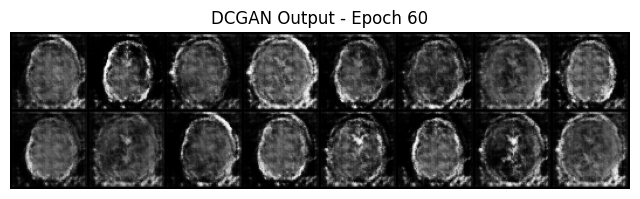

Epoch [80/300]


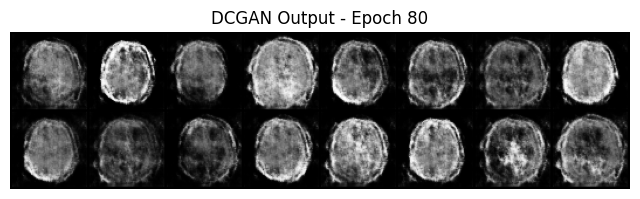

Epoch [100/300]


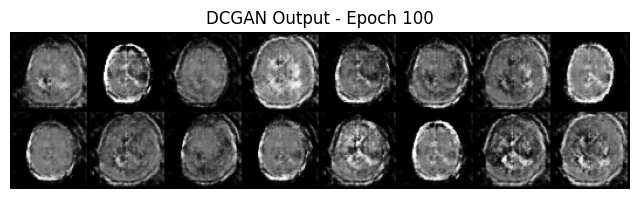

Epoch [120/300]


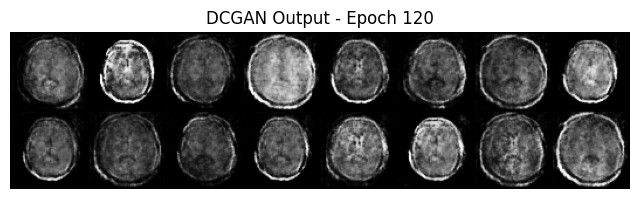

Epoch [140/300]


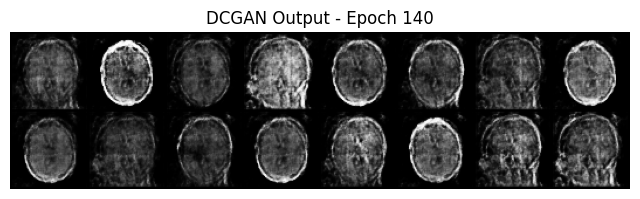

Epoch [160/300]


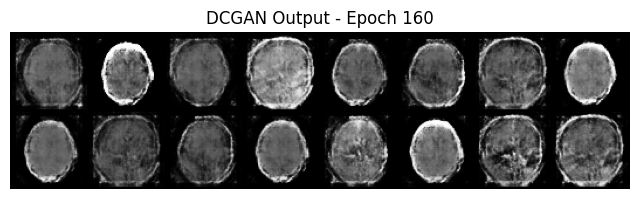

Epoch [180/300]


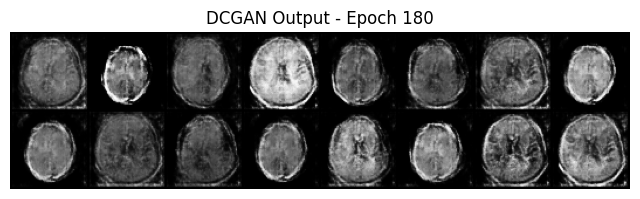

Epoch [200/300]


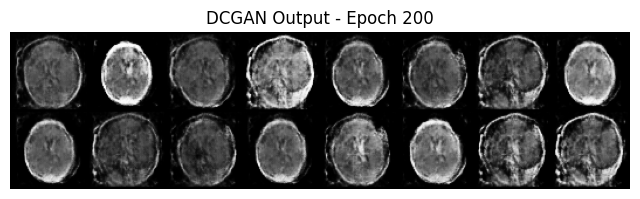

Epoch [220/300]


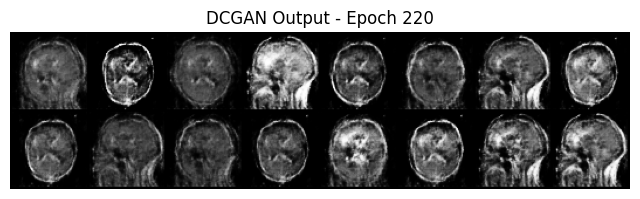

Epoch [240/300]


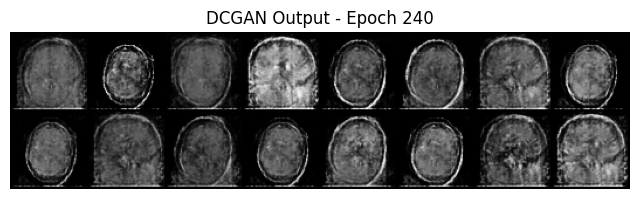

Epoch [260/300]


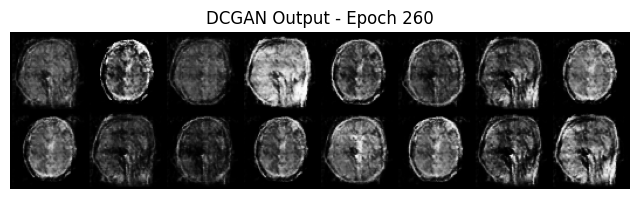

Epoch [280/300]


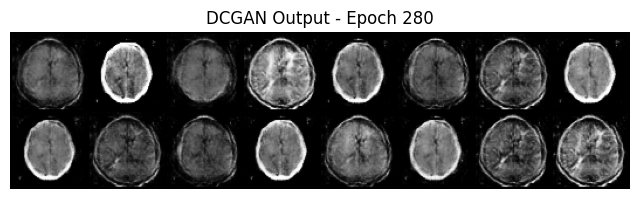

Epoch [300/300]


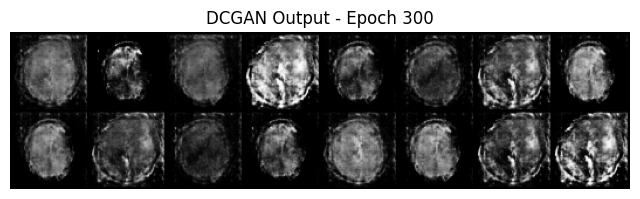

In [46]:
num_epochs = 300 
print("Starting DCGAN Training Loop...")

fixed_noise = torch.randn(16, 100, 1, 1, device=device)

img_list = []
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device) 
        
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0.) 
        
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        netG.zero_grad()
        label.fill_(1.) 
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(8,4))
        plt.axis("off")
        plt.title(f"DCGAN Output - Epoch {epoch+1}")
        plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1,2,0)))
        plt.show()

In [47]:
#WGAN

class WGAN_Generator(nn.Module):
    def __init__(self):
        super(WGAN_Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

class WGAN_Critic(nn.Module):
    def __init__(self):
        super(WGAN_Critic, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        )
    def forward(self, input):
        return self.main(input)

netG_wgan = WGAN_Generator().to(device)
netC_wgan = WGAN_Critic().to(device) 
netG_wgan.apply(weights_init)
netC_wgan.apply(weights_init)

optimizerG_wgan = optim.RMSprop(netG_wgan.parameters(), lr=0.00005)
optimizerC_wgan = optim.RMSprop(netC_wgan.parameters(), lr=0.00005)

Starting WGAN Training...
Epoch [20/400] Loss C: -0.1929


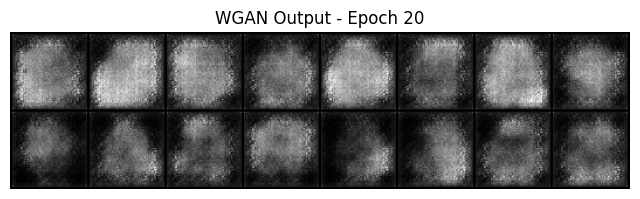

Epoch [40/400] Loss C: -0.8697


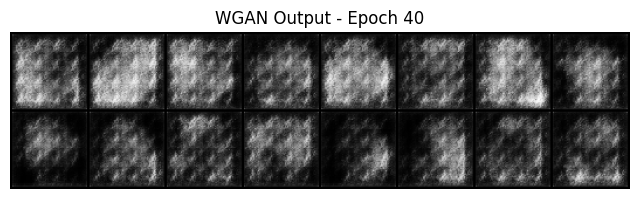

Epoch [60/400] Loss C: -1.1758


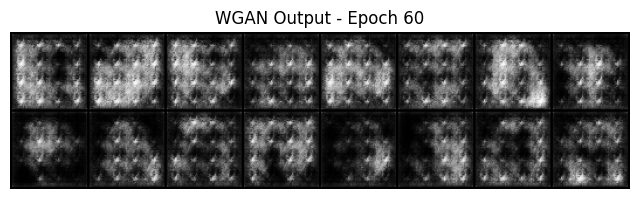

Epoch [80/400] Loss C: -1.2246


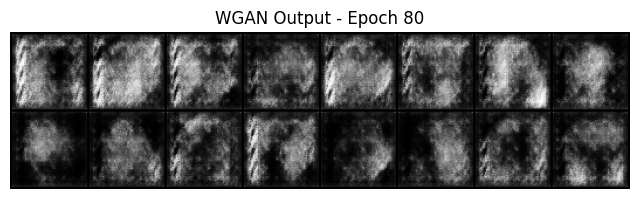

Epoch [100/400] Loss C: -1.1535


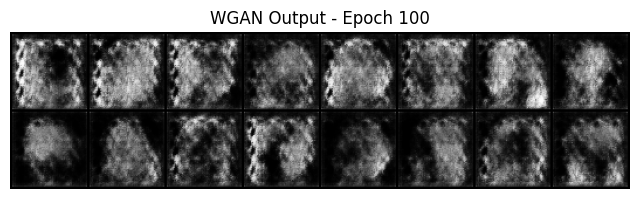

Epoch [120/400] Loss C: -1.1740


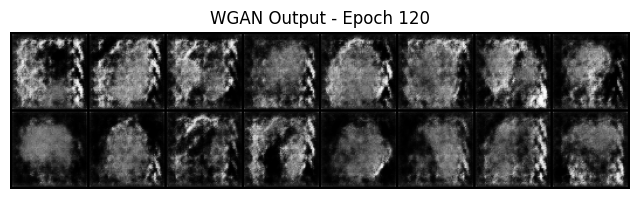

Epoch [140/400] Loss C: -1.1780


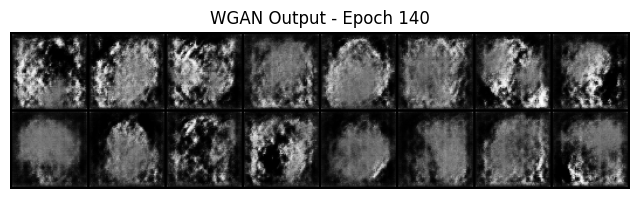

Epoch [160/400] Loss C: -0.6136


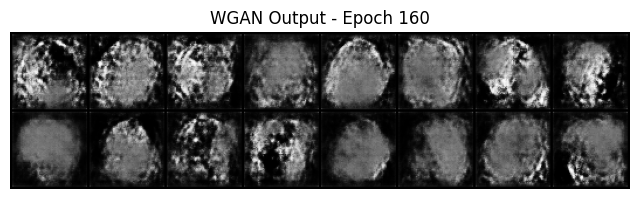

Epoch [180/400] Loss C: -1.2047


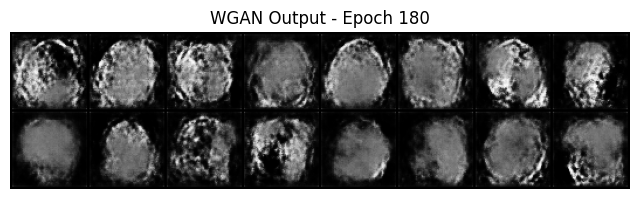

Epoch [200/400] Loss C: -1.1532


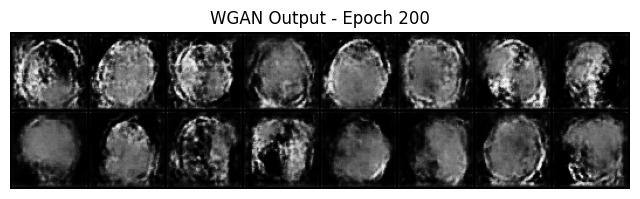

Epoch [220/400] Loss C: -1.1038


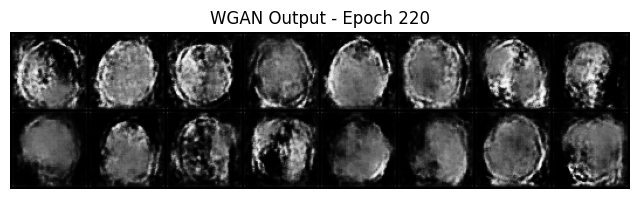

Epoch [240/400] Loss C: -1.1254


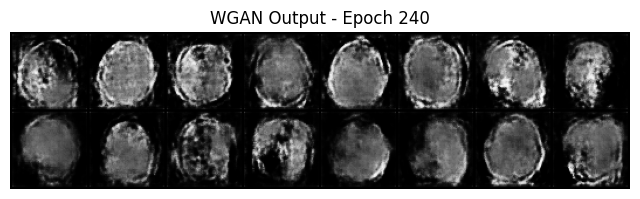

Epoch [260/400] Loss C: -1.0184


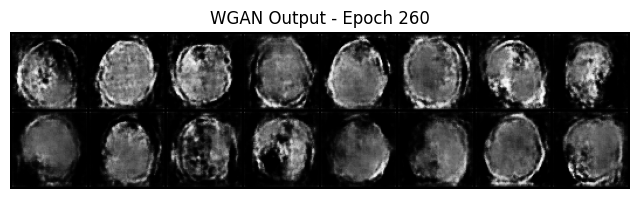

Epoch [280/400] Loss C: -1.1626


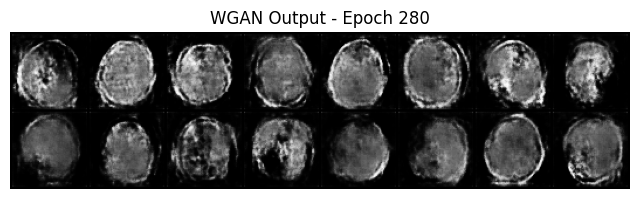

Epoch [300/400] Loss C: -1.0850


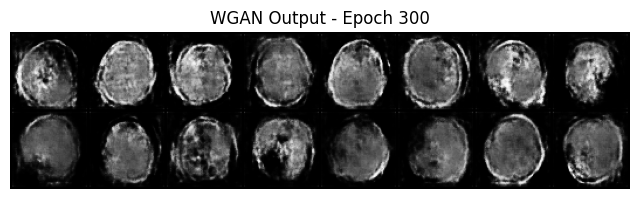

Epoch [320/400] Loss C: -1.1303


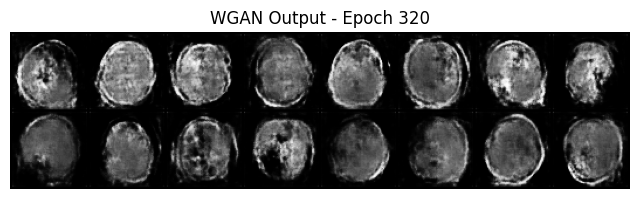

Epoch [340/400] Loss C: -1.1499


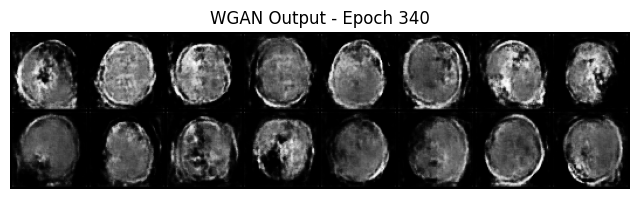

Epoch [360/400] Loss C: -1.1132


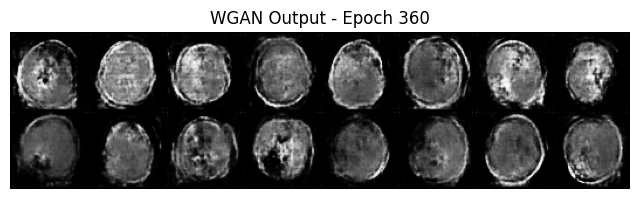

Epoch [380/400] Loss C: -1.0767


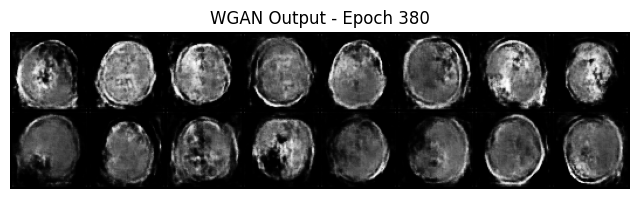

Epoch [400/400] Loss C: -1.0695


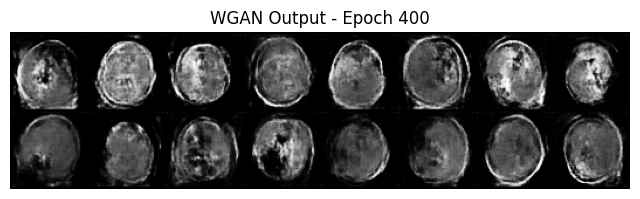

In [48]:
num_epochs = 400
print("Starting WGAN Training...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        
        netC_wgan.zero_grad()
        
        output_real = netC_wgan(real_cpu).view(-1)
        
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = netG_wgan(noise).detach()
        output_fake = netC_wgan(fake).view(-1)
        
        loss_C = -(torch.mean(output_real) - torch.mean(output_fake))
        loss_C.backward()
        optimizerC_wgan.step()
        
        for p in netC_wgan.parameters():
            p.data.clamp_(-0.01, 0.01)

        if i % 5 == 0:
            netG_wgan.zero_grad()
            noise = torch.randn(b_size, 100, 1, 1, device=device)
            fake = netG_wgan(noise)
            output = netC_wgan(fake).view(-1)
            
            loss_G = -torch.mean(output)
            loss_G.backward()
            optimizerG_wgan.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss C: {loss_C.item():.4f}')
        with torch.no_grad():
            fake = netG_wgan(fixed_noise).detach().cpu()
        plt.figure(figsize=(8,4))
        plt.axis("off")
        plt.title(f"WGAN Output - Epoch {epoch+1}")
        plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1,2,0)))
        plt.show()

In [49]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from sklearn.metrics import classification_report, accuracy_score
import torch.nn as nn
import torch.optim as optim


full_dataset = datasets.ImageFolder(root='/kaggle/input/brain-tumor/Training', transform=transform)
full_loader = DataLoader(full_dataset, batch_size=len(full_dataset), shuffle=True)

X_real, y_real = next(iter(full_loader))
X_real, y_real = X_real.to(device), y_real.to(device)

print(f"{len(X_real)}")

minority_class_idx = full_dataset.class_to_idx['no_tumor']

def create_balanced_dataset(generator_model, model_type='vanilla'):
    counts = torch.bincount(y_real)
    max_count = counts.max().item()
    minority_count = counts[minority_class_idx].item()
    needed = max_count - minority_count
    
    print(f"{model_type}: {needed}")
    
    with torch.no_grad():
        if model_type == 'vanilla':
            noise = torch.randn(needed, 150).to(device) 
            fake_imgs = generator_model(noise)
        else: 
            noise = torch.randn(needed, 100, 1, 1).to(device)
            fake_imgs = generator_model(noise)

    X_balanced = torch.cat([X_real, fake_imgs], 0)
    
    new_labels = torch.full((needed,), minority_class_idx, dtype=torch.long, device=device)
    y_balanced = torch.cat([y_real, new_labels], 0)
    
    return TensorDataset(X_balanced, y_balanced)

dataset_orig = TensorDataset(X_real, y_real)

dataset_vanilla = create_balanced_dataset(gen, 'vanilla')

dataset_dcgan = create_balanced_dataset(netG, 'dcgan')

dataset_wgan = create_balanced_dataset(netG_wgan, 'wgan') 

class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 16 * 16, 128), nn.ReLU(),
            nn.Linear(128, 4)
        )
    def forward(self, x):
        return self.fc(self.conv(x))

def evaluate_scenario(dataset, name):
    
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
    
    model = SimpleClassifier().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    for epoch in range(5):
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            _, predicted = torch.max(output, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    print(f"--- results : {name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred, target_names=full_dataset.classes))

evaluate_scenario(dataset_orig, "Original Data (Imbalanced)")
evaluate_scenario(dataset_vanilla, "Vanilla GAN Balanced")
evaluate_scenario(dataset_dcgan, "DCGAN Balanced")
evaluate_scenario(dataset_wgan, "WGAN Balanced")

2870
vanilla: 432
dcgan: 432
wgan: 432
--- results : Original Data (Imbalanced) ---
Accuracy: 0.8380
                  precision    recall  f1-score   support

    glioma_tumor       0.84      0.81      0.82       158
meningioma_tumor       0.79      0.75      0.77       173
        no_tumor       0.88      0.79      0.84        87
 pituitary_tumor       0.86      0.99      0.92       156

        accuracy                           0.84       574
       macro avg       0.84      0.84      0.84       574
    weighted avg       0.84      0.84      0.84       574

--- results : Vanilla GAN Balanced ---
Accuracy: 0.8699
                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.83      0.87       155
meningioma_tumor       0.76      0.85      0.80       176
        no_tumor       0.91      0.89      0.90       161
 pituitary_tumor       0.92      0.92      0.92       169

        accuracy                           0.87       661
       macro avg       0.8

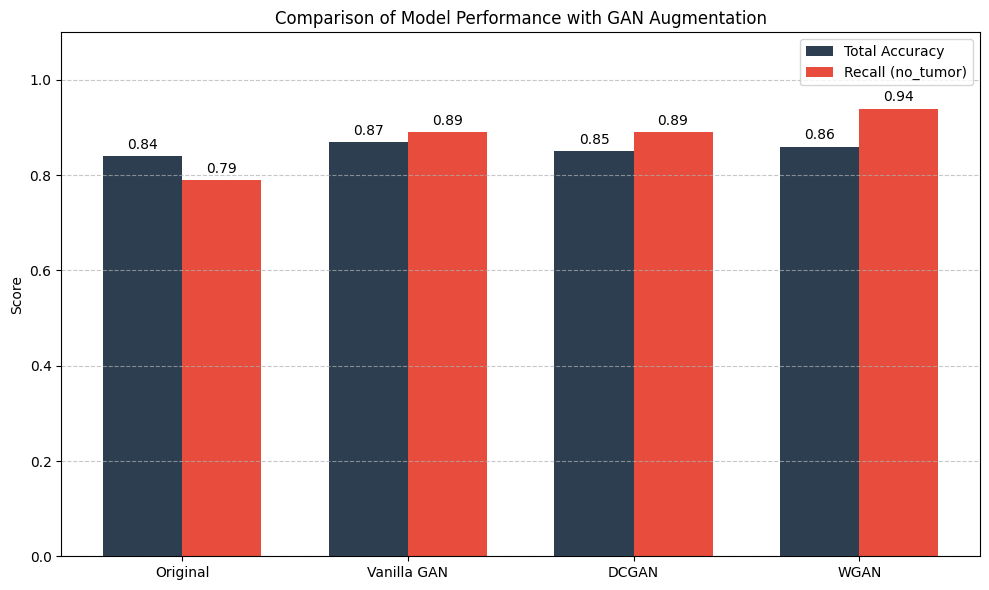

In [51]:
import matplotlib.pyplot as plt
import numpy as np

scenarios = ['Original', 'Vanilla GAN', 'DCGAN', 'WGAN']

accuracy_scores = [0.84, 0.87, 0.85, 0.86] 

recall_scores = [0.79, 0.89, 0.89, 0.94]

x = np.arange(len(scenarios))
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, accuracy_scores, width, label='Total Accuracy', color='#2c3e50')
rects2 = ax.bar(x + width/2, recall_scores, width, label='Recall (no_tumor)', color='#e74c3c')

ax.set_ylabel('Score')
ax.set_title('Comparison of Model Performance with GAN Augmentation')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend()
ax.set_ylim(0, 1.1) 
ax.grid(axis='y', linestyle='--', alpha=0.7)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()